In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/新加坡92#汽油裂解.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['新加坡92#汽油裂解价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡92#汽油裂解价差,美国RBOB汽油裂解,新加坡0.5%低硫燃料油裂解价差,美国经济惊喜指数超季节性/3年,美国首次申领失业金人数/千人/4WMA,全球经济惊喜指数（同花顺）超季节性/3年,汽油ew价差,LME铜价/WTI连1合约价格,PX-WTI价差,Brent-Dubai/7DMA,石脑油-布油价差,新加坡轻质馏分油库存（千桶）超季节性/3年,MTBE开工率,中国汽油出口计划量,RBOB汽油裂解价差（均价）
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/美国RBOB汽油裂解_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/美国RBOB汽油裂解_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/美国RBOB汽油裂解_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['实际值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1 = sheet1.rename(columns={'美国RBOB汽油裂解': '美国RBOB'})
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,美国RBOB
19,2025-11-10,19.59
18,2025-11-11,19.48
17,2025-11-12,19.84
16,2025-11-13,19.71
15,2025-11-14,19.58


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,预测值
20,2025-11-10,7.54
19,2025-11-11,7.67
18,2025-11-12,7.08
17,2025-11-13,7.65
16,2025-11-14,7.43


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/铜/eta/LME铜价_合并数据.xlsx")
]

file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_paths3 = path
        break

if file_paths3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.read_excel(file_paths3, sheet_name='Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['真实值'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,预测值
21,2025-11-08,10670.4
20,2025-11-10,10673.0
19,2025-11-11,10674.6
18,2025-11-12,10677.9
17,2025-11-13,10679.6


In [8]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path4 = None
for path in file_paths4:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path4 = path
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.read_excel(file_path4, sheet_name='Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['wti原油期货价格'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
    sheet4.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,WTI原油期货价格预测
19,2025-11-10,59.92
18,2025-11-11,60.89
17,2025-11-12,60.90
16,2025-11-13,60.89
15,2025-11-14,60.91


In [9]:
sheet4 = pd.merge(sheet4, sheet3, on='Date', how='outer')
sheet4['LME/WTI'] = sheet4['预测值'] / sheet4['WTI原油期货价格预测'] 
sheet4 = sheet4.drop(columns=['预测值','WTI原油期货价格预测'])
sheet4 = sheet4.dropna()

In [10]:
# 尝试多个可能的文件路径
file_paths5 = [
    os.path.expanduser("~/Desktop/X-BASE/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/化工/eta/PX-WTI价差_合并数据.xlsx")
]

file_path5 = None
for path5 in file_paths5:
    if os.path.isfile(path5):  # 确保是文件而不是目录
        file_path5 = path5  # 修正变量名
        break

if file_path5 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet5 = pd.read_excel(file_path5, sheet_name='Sheet1')
    sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
    sheet5 = sheet5.drop(columns=['真实值'])
    sheet5 = sheet5.dropna()
    sheet5 = sheet5.sort_values('Date', ascending=True)
    sheet5.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet5.head()

,Date,预测值
19,2025-11-07,390.8
18,2025-11-10,402.9
17,2025-11-11,404.3
16,2025-11-12,402.6
15,2025-11-13,399.3


In [11]:
file_path6 = os.path.expanduser("eta/中国汽油出口计划量_合并数据.xlsx") 
sheet6 = pd.ExcelFile(file_path6).parse('Sheet1')
sheet6['Date'] = pd.to_datetime(sheet6['Date'], errors='coerce')
sheet6 = sheet6.drop(columns=['真实值'])
sheet6 = sheet6.dropna()

sheet6 = sheet6.sort_values('Date', ascending=True)
sheet6.tail()

,Date,预测值
0,2025-12-31,58.5


In [12]:
file_path7 = os.path.expanduser("eta/RBOB汽油裂解价差（均价）_合并数据.xlsx") 
sheet7 = pd.ExcelFile(file_path7).parse('Sheet1')
sheet7['Date'] = pd.to_datetime(sheet7['Date'], errors='coerce')
sheet7 = sheet7.drop(columns=['真实值'])
sheet7 = sheet7.dropna()
sheet7 = sheet7.sort_values('Date', ascending=True)
sheet7.tail()

,Date,预测值
4,2025-12-01,20.9
3,2025-12-02,20.9
2,2025-12-03,20.8
1,2025-12-04,20.6
0,2025-12-05,20.7


In [13]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '美国RBOB']],
    on='Date',
    how='left'
)
sheet_daily['美国RBOB汽油裂解'] = sheet_daily['美国RBOB汽油裂解'].fillna(sheet_daily['美国RBOB'])
sheet_daily = sheet_daily.drop(columns=['美国RBOB'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡0.5%低硫燃料油裂解价差'] = sheet_daily['新加坡0.5%低硫燃料油裂解价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', 'LME/WTI']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价/WTI连1合约价格'] = sheet_daily['LME铜价/WTI连1合约价格'].fillna(sheet_daily['LME/WTI'])
sheet_daily = sheet_daily.drop(columns=['LME/WTI'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PX-WTI价差'] = sheet_daily['PX-WTI价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet6[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['中国汽油出口计划量'] = sheet_daily['中国汽油出口计划量'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet7[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['RBOB汽油裂解价差（均价）'] = sheet_daily['RBOB汽油裂解价差（均价）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [14]:
sheet.columns

Index(['新加坡92#汽油裂解价差', '美国RBOB汽油裂解', '新加坡0.5%低硫燃料油裂解价差', '美国经济惊喜指数超季节性/3年',
       '美国首次申领失业金人数/千人/4WMA', '全球经济惊喜指数（同花顺）超季节性/3年', '汽油ew价差',
       'LME铜价/WTI连1合约价格', 'PX-WTI价差', 'Brent-Dubai/7DMA', '石脑油-布油价差',
       '新加坡轻质馏分油库存（千桶）超季节性/3年', 'MTBE开工率', '中国汽油出口计划量', 'RBOB汽油裂解价差（均价）'],
      dtype='object')

In [15]:
################################# 处理缺失值 #################################
fill_methods = {
'美国RBOB汽油裂解':'interpolate', 
'新加坡0.5%低硫燃料油裂解价差':'interpolate', 
'美国经济惊喜指数超季节性/3年':'interpolate',
'美国首次申领失业金人数/千人/4WMA':'interpolate', 
'全球经济惊喜指数（同花顺）超季节性/3年':'interpolate', 
'汽油ew价差':'interpolate',
'LME铜价/WTI连1合约价格':'interpolate', 
'PX-WTI价差':'interpolate', 
'Brent-Dubai/7DMA':'interpolate',
'石脑油-布油价差':'interpolate',
'新加坡轻质馏分油库存（千桶）超季节性/3年':'interpolate',
'MTBE开工率':'interpolate',
'中国汽油出口计划量':'interpolate',
'RBOB汽油裂解价差（均价）':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['美国经济惊喜指数超季节性/3年_提前20天'] = sheet['美国经济惊喜指数超季节性/3年'].shift(20)
sheet['美国首次申领失业金人数/千人/4WMA_提前25天'] = sheet['美国首次申领失业金人数/千人/4WMA'].shift(25)
sheet['全球经济惊喜指数（同花顺）超季节性/3年_提前80天'] = sheet['全球经济惊喜指数（同花顺）超季节性/3年'].shift(80)
sheet['汽油ew价差_提前90天'] = sheet['汽油ew价差'].shift(90)
sheet['Brent-Dubai/7DMA_提前20天'] = sheet['Brent-Dubai/7DMA'].shift(20)
sheet['石脑油-布油价差_提前21天'] = sheet['石脑油-布油价差'].shift(21)
sheet['新加坡轻质馏分油库存（千桶）超季节性/3年_提前21天'] = sheet['新加坡轻质馏分油库存（千桶）超季节性/3年'].shift(21)
sheet['MTBE开工率_提前21天'] = sheet['MTBE开工率'].shift(21)


sheet['美国首次申领失业金人数/千人/4WMA_提前25天_逆序'] = reverse_column(sheet, '美国首次申领失业金人数/千人/4WMA_提前25天')
sheet['LME铜价/WTI连1合约价格_逆序'] = reverse_column(sheet, 'LME铜价/WTI连1合约价格')
sheet['石脑油-布油价差_提前21天_逆序'] = reverse_column(sheet, '石脑油-布油价差_提前21天')
sheet['新加坡轻质馏分油库存（千桶）超季节性/3年_提前21天_逆序'] = reverse_column(sheet, '新加坡轻质馏分油库存（千桶）超季节性/3年_提前21天')
sheet['MTBE开工率_提前21天_逆序'] = reverse_column(sheet, 'MTBE开工率_提前21天')
sheet['中国汽油出口计划量_逆序'] = reverse_column(sheet, '中国汽油出口计划量')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['新加坡92#汽油裂解价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

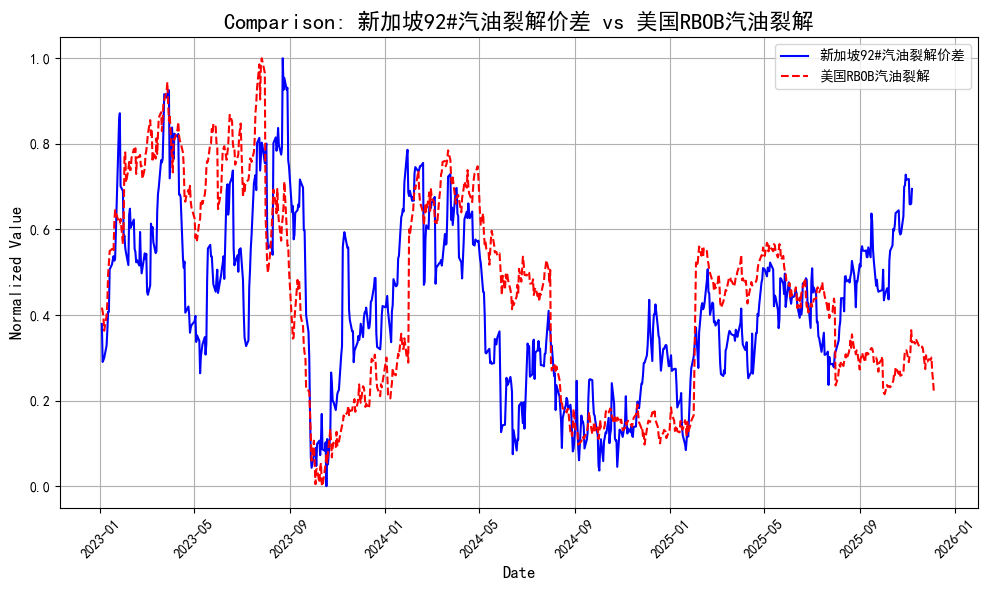

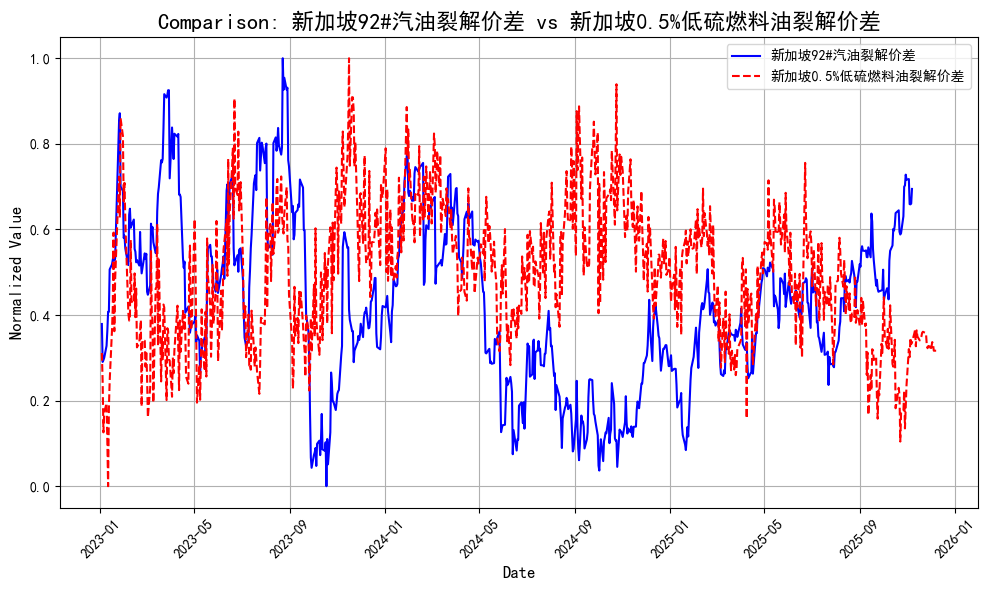

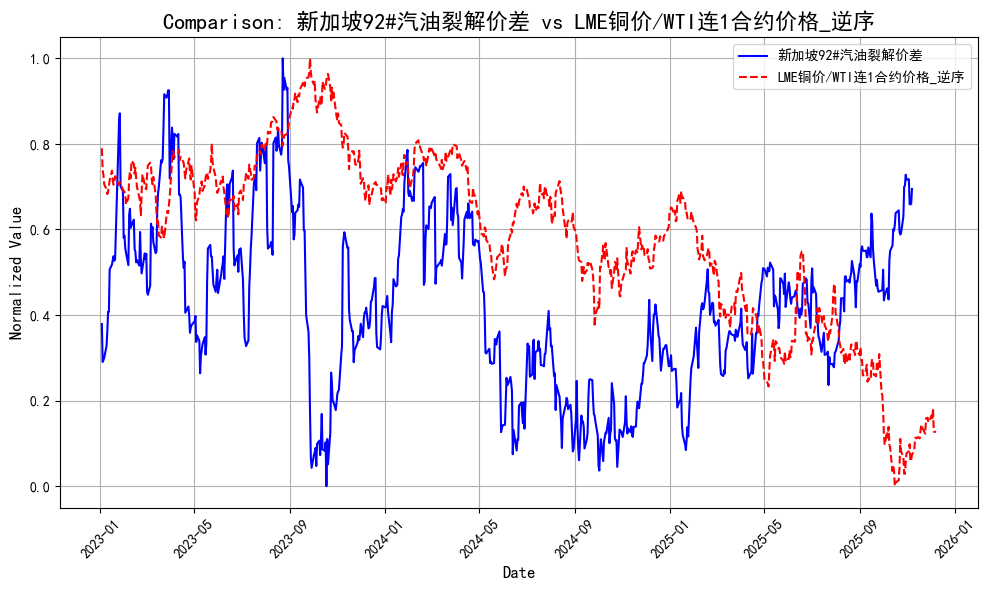

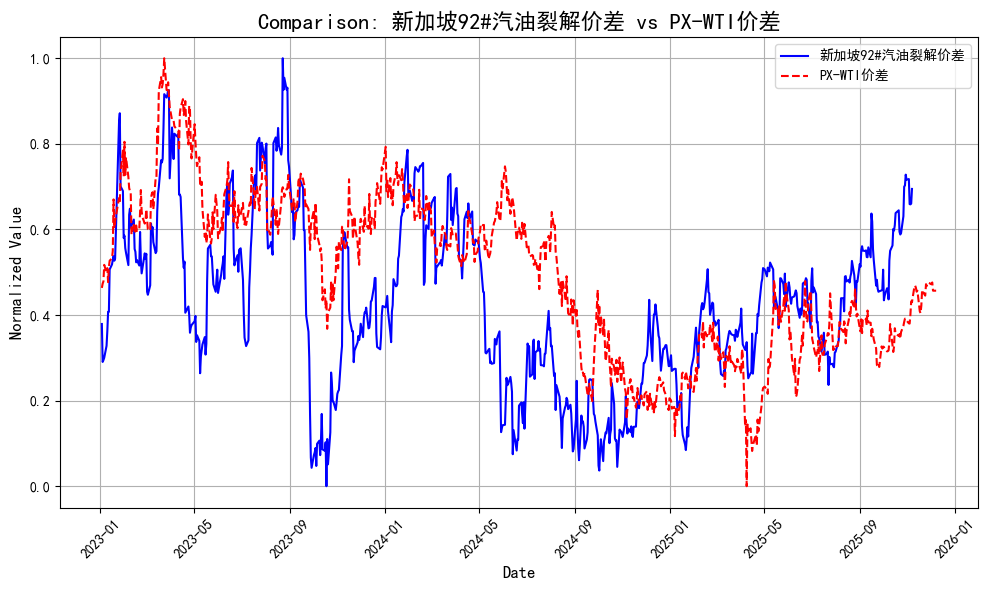

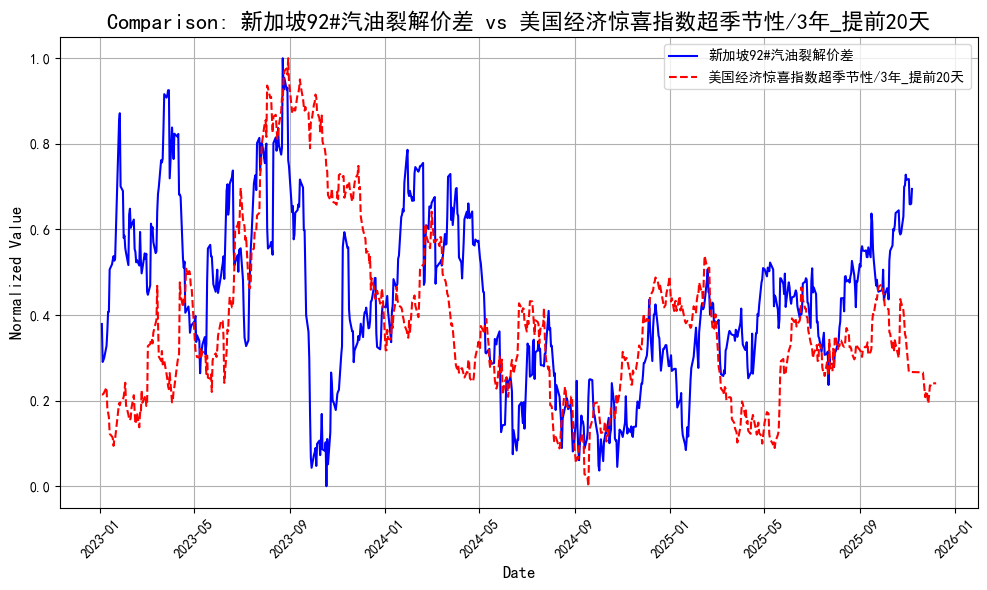

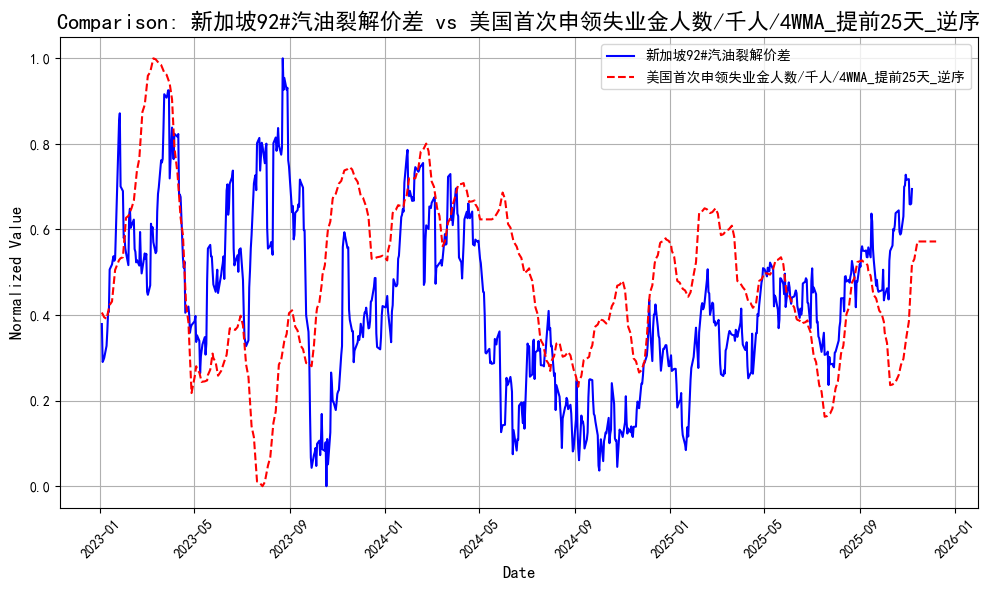

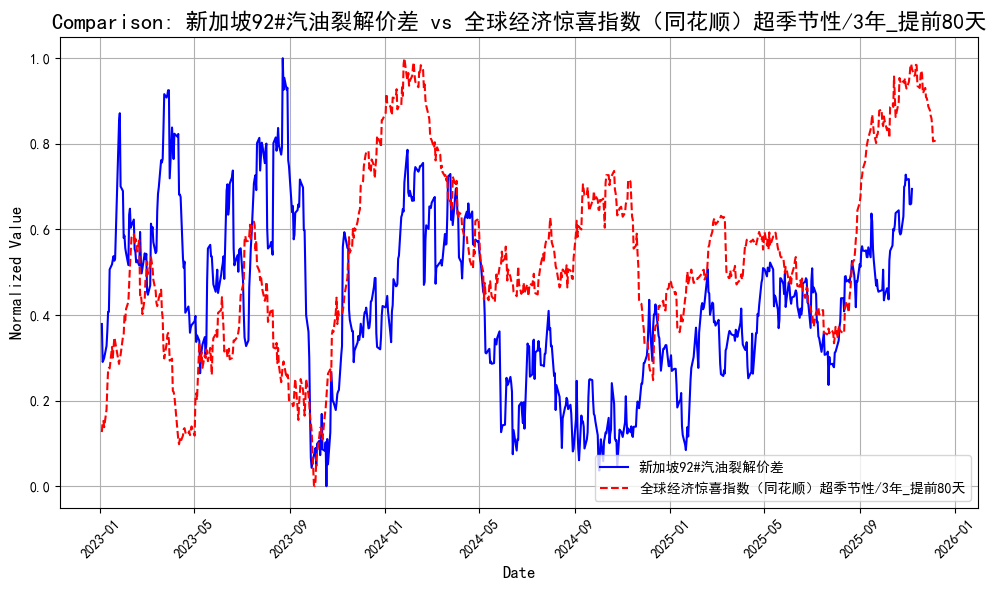

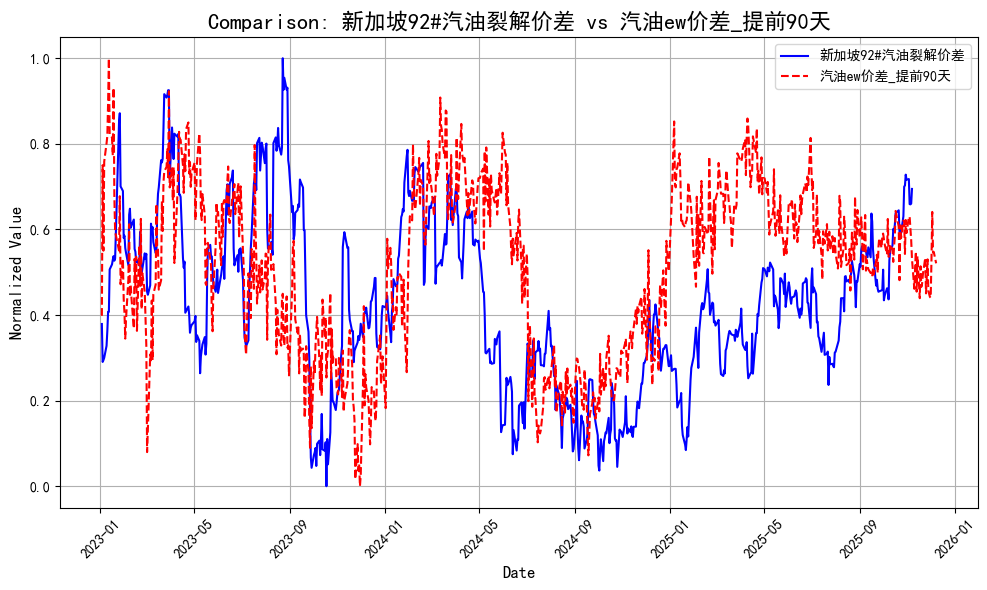

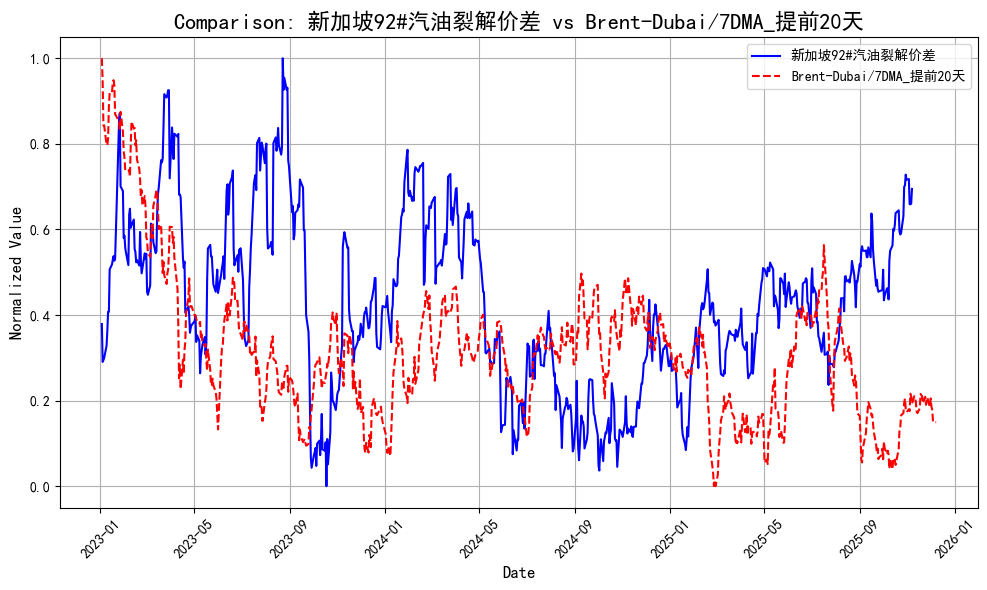

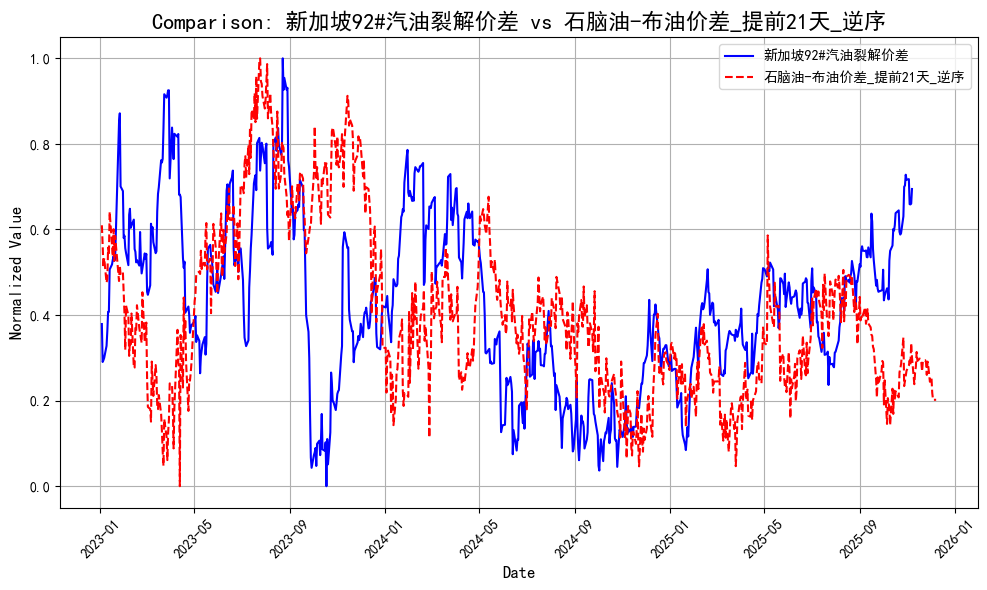

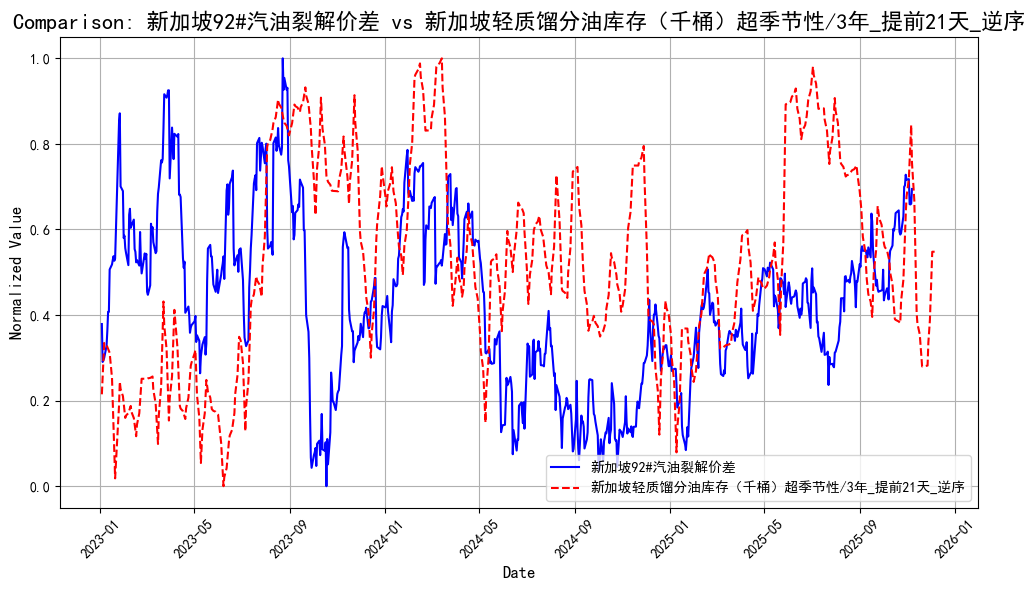

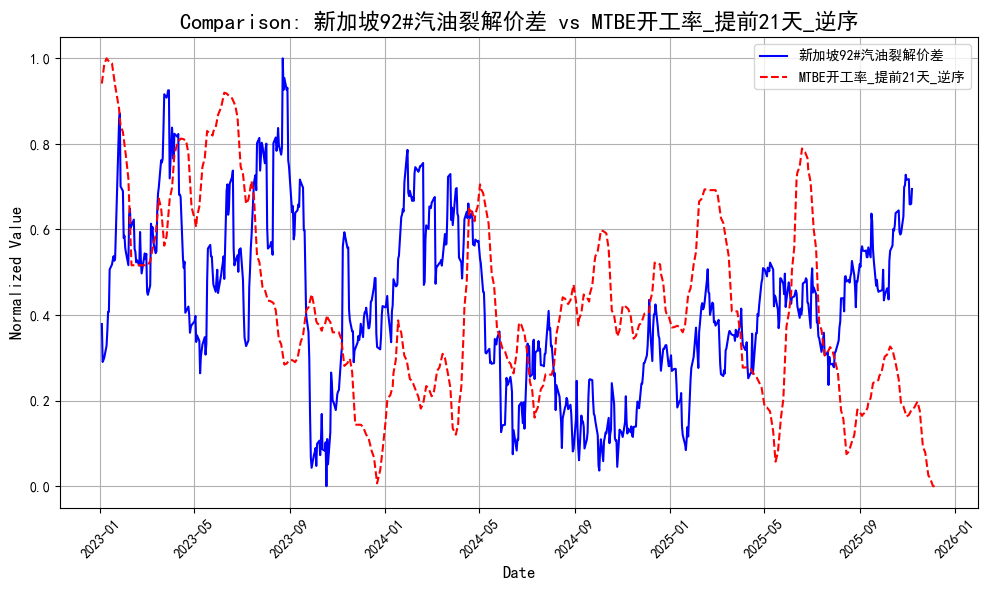

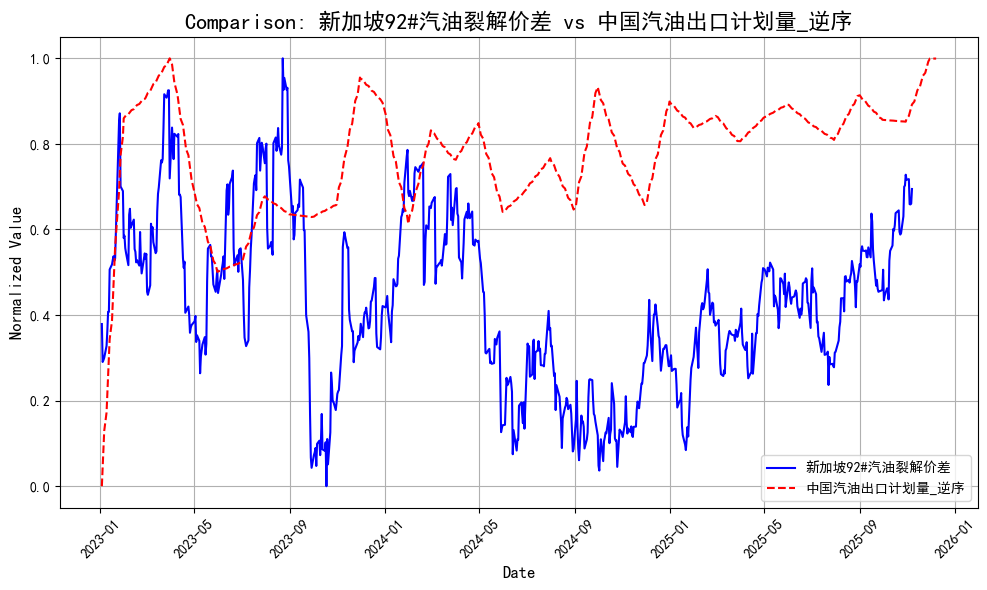

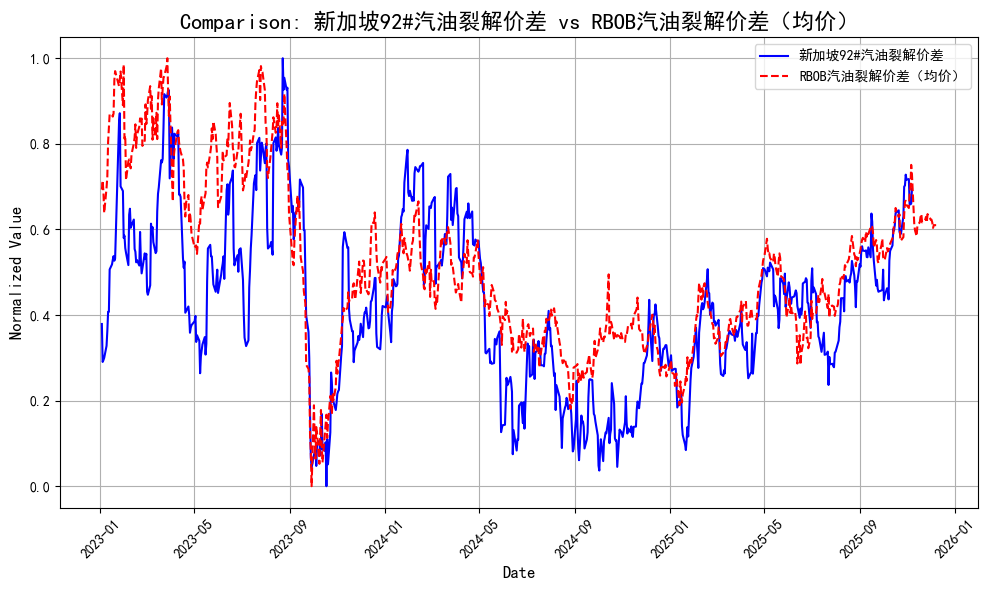

In [16]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='新加坡92#汽油裂解价差', 
    compare_cols=[
        '美国RBOB汽油裂解',
        '新加坡0.5%低硫燃料油裂解价差',
        'LME铜价/WTI连1合约价格_逆序',
        'PX-WTI价差',
        '美国经济惊喜指数超季节性/3年_提前20天',
        '美国首次申领失业金人数/千人/4WMA_提前25天_逆序',
        '全球经济惊喜指数（同花顺）超季节性/3年_提前80天',
        '汽油ew价差_提前90天',
        'Brent-Dubai/7DMA_提前20天',
        '石脑油-布油价差_提前21天_逆序',
        '新加坡轻质馏分油库存（千桶）超季节性/3年_提前21天_逆序',
        'MTBE开工率_提前21天_逆序',
        '中国汽油出口计划量_逆序',
        'RBOB汽油裂解价差（均价）'
        ]
)

In [17]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 5
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
#        '美国RBOB汽油裂解',
        '新加坡0.5%低硫燃料油裂解价差',
#        'LME铜价/WTI连1合约价格_逆序',
#        'PX-WTI价差',
        '美国经济惊喜指数超季节性/3年_提前20天',
        '美国首次申领失业金人数/千人/4WMA_提前25天_逆序',
        '全球经济惊喜指数（同花顺）超季节性/3年_提前80天',
        '汽油ew价差_提前90天',
        'Brent-Dubai/7DMA_提前20天',
        '石脑油-布油价差_提前21天_逆序',
        '新加坡轻质馏分油库存（千桶）超季节性/3年_提前21天_逆序',
        'MTBE开工率_提前21天_逆序',
        '中国汽油出口计划量_逆序',
        'RBOB汽油裂解价差（均价）'
]

predict_column = '新加坡92#汽油裂解价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.04882050188829679, 
    'max_depth': 8, 
    'min_child_weight': 1.0220124909175812, 
    'subsample': 0.6919581563376909, 
    'colsample_bytree': 0.8755284797291629, 
    'gamma': 0.05675346191631542, 
    'reg_alpha': 0.2080521846242907, 
    'reg_lambda': 0.557687452781208,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:4.56022	train-rmse:3.42702


[500]	eval-rmse:0.89555	train-rmse:0.13666


[1000]	eval-rmse:0.88733	train-rmse:0.13146


[1500]	eval-rmse:0.88999	train-rmse:0.12859


[2000]	eval-rmse:0.88990	train-rmse:0.12681


[2500]	eval-rmse:0.88214	train-rmse:0.12538


[3000]	eval-rmse:0.87901	train-rmse:0.12467


[3500]	eval-rmse:0.88419	train-rmse:0.12402


[4000]	eval-rmse:0.88422	train-rmse:0.12360


[4500]	eval-rmse:0.88161	train-rmse:0.12294


[4999]	eval-rmse:0.88084	train-rmse:0.12235


训练集 MSE (DMatrix): 0.0156, 训练集 R² (DMatrix): 0.9989
测试集 MSE (DMatrix): 0.7759, 测试集 R² (DMatrix): -2.8613


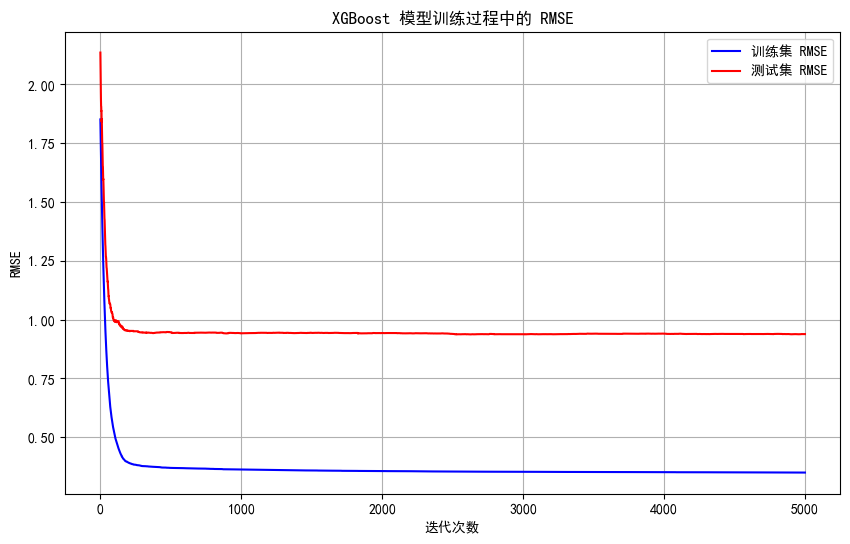

In [18]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:3.44105


[500]	train-rmse:0.13870


[1000]	train-rmse:0.13187


[1500]	train-rmse:0.12917


[2000]	train-rmse:0.12699


[2500]	train-rmse:0.12523


[3000]	train-rmse:0.12427


[3500]	train-rmse:0.12373


[4000]	train-rmse:0.12286


[4500]	train-rmse:0.12192


[4999]	train-rmse:0.12142


全部数据 MSE: 0.0152, 全部数据 R²: 0.9989


Gap between last actual value and first prediction: 0.766153602600097


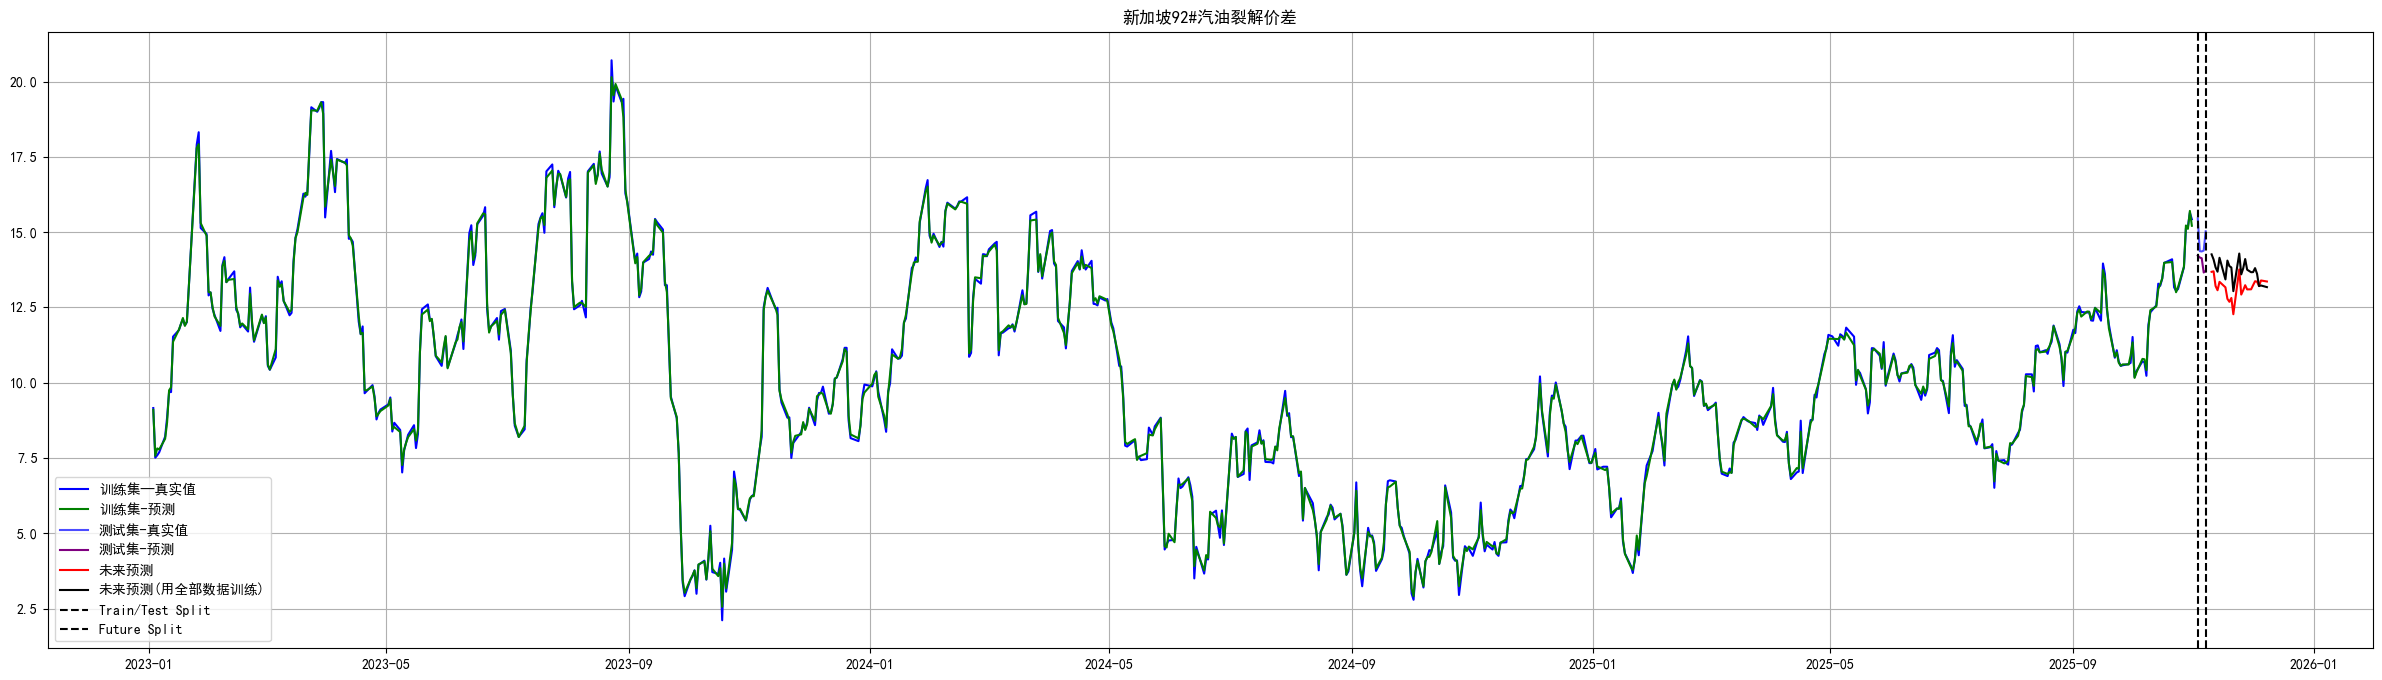

In [20]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('新加坡92#汽油裂解价差')
plt.legend()
plt.grid(True)
plt.show()

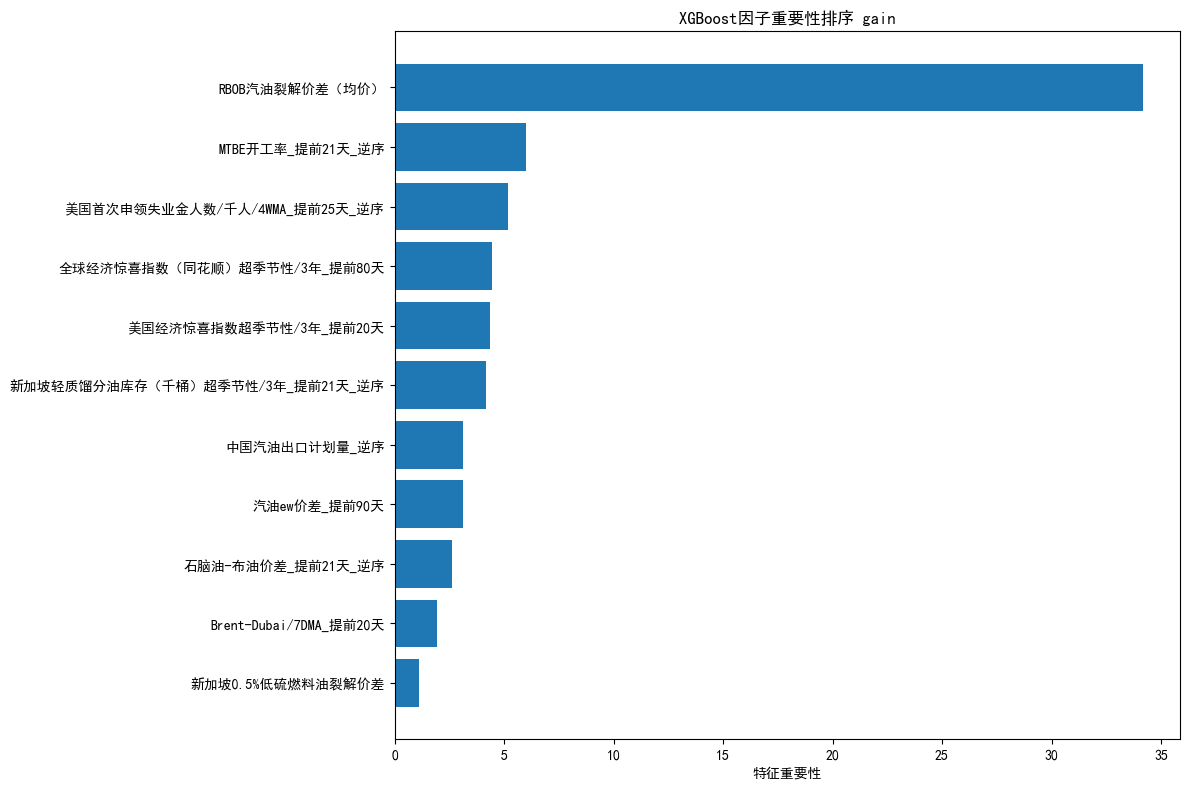

In [21]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'gain'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()



---

In [22]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/新加坡92#汽油裂解价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
737,2025/12/08,NaN,13.175742
736,2025/12/05,NaN,13.229698
735,2025/12/04,NaN,13.209318
734,2025/12/03,NaN,13.619810
733,2025/12/02,NaN,13.806437
...,...,...,...
4,2023/01/09,8.21,NaN
3,2023/01/06,7.69,NaN
2,2023/01/05,7.59,NaN
1,2023/01/04,7.51,NaN


In [23]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
# 删除真实值和预测值都为空的行
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')

merged_df_monthly.to_excel('eta/新加坡92#汽油裂解价差_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,13.452531
34,2025/11/30,14.722000,13.875322
33,2025/10/31,12.870909,12.867376
32,2025/09/30,11.863182,11.863397
31,2025/08/31,10.344762,10.356897


In [24]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡92#汽油裂解价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [25]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡92#汽油裂解价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
